In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wave_bwf_rf64 
import contextlib
import math
from scipy import signal

Vett jel

In [2]:
filename = "1090.wav"
with contextlib.closing(wave_bwf_rf64.open(filename,'rb')) as f:
    fs = f.getframerate()
    num_frames = f.getnframes()
    iq_samples = f.readframes(num_frames)
iq_samples = np.frombuffer(iq_samples, dtype=np.int16) 
I = iq_samples[0::2]
Q = iq_samples[1::2]
iq_samples = I + 1j * Q
iq_samples = np.abs(iq_samples)
#plt.plot(iq_samples[:10000000])

KeyboardInterrupt: 

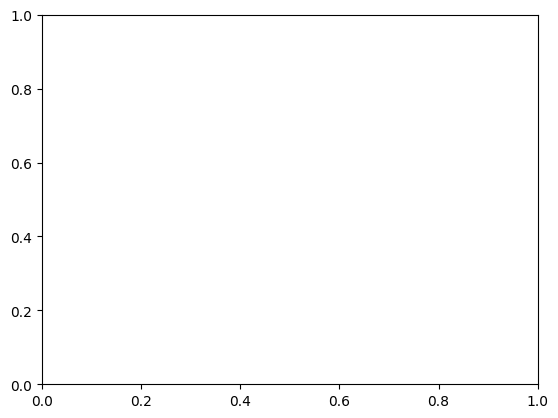

In [65]:
plt.plot(iq_samples)

In [4]:
iq_samples = signal.resample_poly(iq_samples,up = 5,down=3)
#plt.plot(iq_samples[:10000000])
len(iq_samples)

54231040

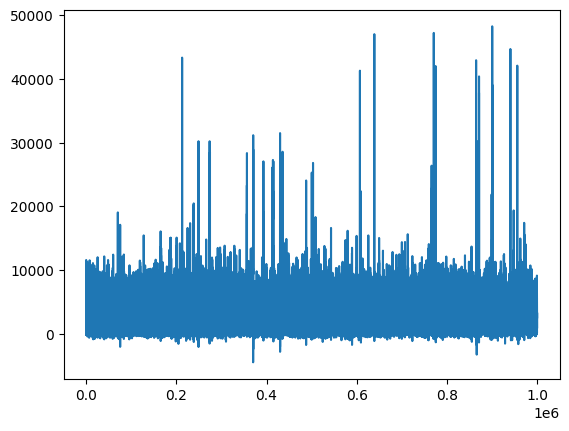

In [6]:
#iq_samples = (iq_samples/np.max(np.abs(iq_samples)))
plt.plot(iq_samples[4500000:5500000])

Megpróbáltam kiszűrni a közepét: lehet nem érdemes kiszűrni, mivel 1 minta van bitenként és lehet információvesztéssel járni

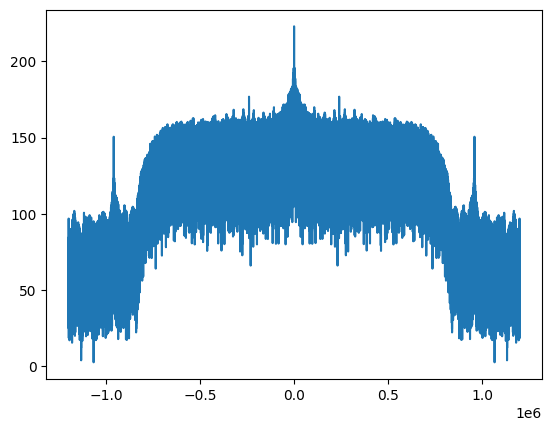

In [5]:
amp = np.abs(np.fft.fftshift(np.fft.fft(iq_samples)))
spec = 20*np.log10(amp)
freq = np.linspace(-fs/2,fs/2,len(spec))
plt.plot(freq,spec)

Preamble + Downlink Format mintázat: összes lehetséges mintázatot meg kell néznünk, mivel nem tudjuk hol kezdtük a mintavételezést

<function matplotlib.pyplot.show(close=None, block=None)>

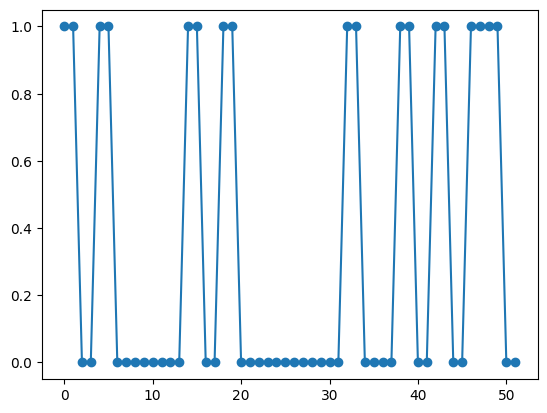

In [4]:
"""s_nk = list()
Tb = 0.5*10**-6
M = 26
N = math.ceil(M*Tb/Ts)
for n in range(N):
    t = n*Ts
    s_nk.append((t%Tb))
s_nk.sort()"""
fs = 4000000
Ts = 1/fs
length = num_frames*Ts
#--------PREAMBLE--------#
a1 = 0
a2 = 0.5*10**-6
b1 = 1*10**-6
b2 = 1.5*10**-6
c1 = 3.5*10**-6
c2 = 4*10**-6
d1 = 4.5*10**-6
d2 = 5*10**-6
#------------------------#
#-----------DF-----------##     10 01 01 01 10       #
e1 = 8*10**-6
e2 = 8.5*10**-6
f1 = 9.5*10**-6
f2 = 10*10**-6
g1 = 10.5*10**-6
g2 = 11*10**-6
h1 = 11.5*10**-6
h2 = 12.5*10**-6
#------------------------#
preamble_df = np.arange(0*10**-6,13*10**-6,Ts)

for i in range(len(preamble_df)):
    if  ((a1 <= preamble_df[i] < a2) or (d1 <= preamble_df[i] < d2) or (c1 <= preamble_df[i] < c2) or (b1 <= preamble_df[i] < b2)) or ((e1 <= preamble_df[i] < e2) or (f1 <= preamble_df[i] < f2) or (g1 <= preamble_df[i] < g2) or (h1 <= preamble_df[i] < h2)):
        preamble_df[i] = 1
    else:
        preamble_df[i] = 0
time_preamble = np.arange(0,len(preamble_df)*Ts,Ts)
plt.plot(preamble_df,marker = "o")
plt.show

Kereszt korreláció a PREAMBLE-DF minta és vett jel közt

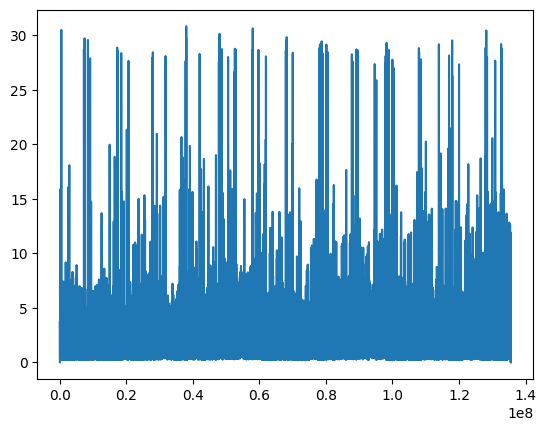

In [8]:
conv = np.correlate(preamble_df,iq_samples,"full")
#plt.plot(a)
#plt.plot(b)
#plt.plot(preamble)
#plt.plot(iq_samples)
#time_conv = np.arange(0,len(conv)*Ts,Ts)
plt.plot(conv)

Relatív mintázat keresése: egymás utáni minták, majd ha van stimmelő sorozat, ellenőrizzük nem e zaj

In [5]:
arg = list()
for i in range(len(iq_samples)-len(preamble_df)-1):
# az 1 esek nagyobbak mint a 0-k
    if (iq_samples[i] > iq_samples[i+2] and
        iq_samples[i+1] > iq_samples[i+2] and
        iq_samples[i+3] < iq_samples[i+4] and
        iq_samples[i+5] > iq_samples[i+3] and
        iq_samples[i+14] > iq_samples[i+13] and
        iq_samples[i+15] > iq_samples[i+13] and
        iq_samples[i+17] < iq_samples[i+19] and
        iq_samples[i+17] > iq_samples[i+18] and        
        iq_samples[i+16] > iq_samples[i+15] and
        iq_samples[i+16] > iq_samples[i+17] and
        iq_samples[i+19] > iq_samples[i+18] and
        iq_samples[i+32] > iq_samples[i+31] and
        iq_samples[i+33] > iq_samples[i+31] and
        iq_samples[i+38] > iq_samples[i+37] and
        iq_samples[i+39] > iq_samples[i+37] and
        iq_samples[i+42] > iq_samples[i+41] and
        iq_samples[i+43] > iq_samples[i+41] and
        iq_samples[i+49] > iq_samples[i+45] and
        iq_samples[i+48] > iq_samples[i+45] and
        iq_samples[i+47] > iq_samples[i+45] and
        iq_samples[i+46] > iq_samples[i+45] 
        ):
            arg.append(i)
len(arg)

3027

A legnagyobb 0 is a legkisebb 1 alatt

In [6]:
#0 2 7 9 16 19 21 23 24 bitek '1' esek
#01 45 1415
#10 11 12 13 14 15
max_zeros = 0
min_ones = 0
for i in arg:
    max_zeros = np.max([iq_samples[i+2],iq_samples[i+3],
                        iq_samples[i+3*2],iq_samples[i+3*2+1],
                        iq_samples[i+4*2],iq_samples[i+4*2+1],
                        iq_samples[i+5*2],iq_samples[i+5*2+1],
                        iq_samples[i+6*2],iq_samples[i+6*2+1],
                        iq_samples[i+10*2],iq_samples[i+10*2+1],
                       iq_samples[i+11*2],iq_samples[i+11*2+1],
                       iq_samples[i+12*2],iq_samples[i+12*2+1],
                       iq_samples[i+13*2],iq_samples[i+13*2+1],
                       iq_samples[i+14*2],iq_samples[i+14*2+1],
                       iq_samples[i+15*2],iq_samples[i+15*2+1]
                       ])
    min_ones = np.min([iq_samples[i],iq_samples[i+1],iq_samples[i+4],iq_samples[i+5],iq_samples[i+7*2],iq_samples[i+7*2+1],iq_samples[i+9*2],
                       iq_samples[i+9*2+1],iq_samples[i+16*2],iq_samples[i+16*2+1],
                       iq_samples[i+19*2],iq_samples[i+19*2+1],iq_samples[i+21*2],iq_samples[i+21*2+1],iq_samples[i+23*2],iq_samples[i+23*2+1],
                       iq_samples[i+24*2],iq_samples[i+24*2+1]
                       ])
    if (min_ones < max_zeros):
        arg.remove(i)
len(arg)

1513

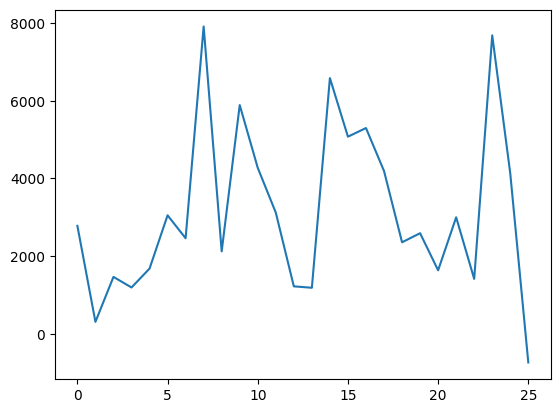

In [44]:
plt.plot(iq_samples[arg[1]:arg[1]+26])

Az átlagos eltérés max A/2, ahol A a legnagyobb és legkisebb közti táv

In [7]:
A  = 0
# az átlag 1 és átlag 0 közti különbség legalább A/2 legyen
for i in arg:
    min =np.min([iq_samples[i+3*2],iq_samples[i+3*2+1],
                        iq_samples[i+4*2],iq_samples[i+4*2+1],
                        iq_samples[i+5*2],iq_samples[i+5*2+1],
                        iq_samples[i+6*2],iq_samples[i+6*2+1],
                        iq_samples[i+10*2],iq_samples[i+10*2+1],
                       iq_samples[i+11*2],iq_samples[i+11*2+1],
                       iq_samples[i+12*2],iq_samples[i+12*2+1],
                       iq_samples[i+13*2],iq_samples[i+13*2+1],
                       iq_samples[i+14*2],iq_samples[i+14*2+1],
                       iq_samples[i+15*2],iq_samples[i+15*2+1]
                       ])
    max = np.max([iq_samples[i],iq_samples[i+1],iq_samples[i+4],iq_samples[i+5],iq_samples[i+7*2],iq_samples[i+7*2+1],iq_samples[i+9*2],
                       iq_samples[i+9*2+1],iq_samples[i+16*2],iq_samples[i+16*2+1],
                       iq_samples[i+19*2],iq_samples[i+19*2+1],iq_samples[i+21*2],iq_samples[i+21*2+1],iq_samples[i+23*2],iq_samples[i+23*2+1],
                       iq_samples[i+24*2],iq_samples[i+24*2+1]
                       ])
    A = max-min
    avg_zeros = np.average([iq_samples[i+3*2],iq_samples[i+3*2+1],
                        iq_samples[i+4*2],iq_samples[i+4*2+1],
                        iq_samples[i+5*2],iq_samples[i+5*2+1],
                        iq_samples[i+6*2],iq_samples[i+6*2+1],
                        iq_samples[i+10*2],iq_samples[i+10*2+1],
                       iq_samples[i+11*2],iq_samples[i+11*2+1],
                       iq_samples[i+12*2],iq_samples[i+12*2+1],
                       iq_samples[i+13*2],iq_samples[i+13*2+1],
                       iq_samples[i+14*2],iq_samples[i+14*2+1],
                       iq_samples[i+15*2],iq_samples[i+15*2+1]
                       ])
    avg_ones = np.average([iq_samples[i],iq_samples[i+1],iq_samples[i+4],iq_samples[i+5],iq_samples[i+7*2],iq_samples[i+7*2+1],iq_samples[i+9*2],
                       iq_samples[i+9*2+1],iq_samples[i+16*2],iq_samples[i+16*2+1],
                       iq_samples[i+19*2],iq_samples[i+19*2+1],iq_samples[i+21*2],iq_samples[i+21*2+1],iq_samples[i+23*2],iq_samples[i+23*2+1],
                       iq_samples[i+24*2],iq_samples[i+24*2+1]
                       ])
    if ((avg_ones-avg_zeros) < (3*A/4)):
        arg.remove(i)
len(arg)

756

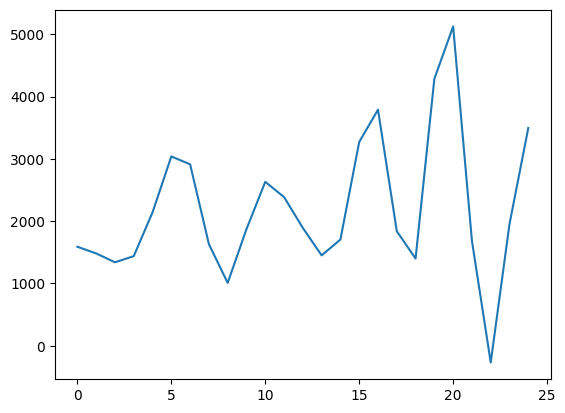

In [ ]:
conv = list()
max_arg = 0
plt.plot(iq_samples[arg[21]:arg[21]+25])

for i in range(len(arg)):
    conv.append(np.correlate(preamble_df,iq_samples[arg[i]:arg[i]+len(preamble_df)-1]))

max_iq = np.argmax(conv)

Első kiugró találat/eredmény: lehet hogy nem kellene abs hogy a negatív értékeket ne számítsuk bele

In [73]:
#lim = np.min(conv)+((np.max(conv)-np.min(conv))/2)
lim = 30
argument = arg[0]

for i in range(len(conv)):
    if ((conv[i] > lim)):
        arg = i
        break
print(argument)

16545


### KISEBB A KERESENDŐ MINTA AMPLITÚDÓJA

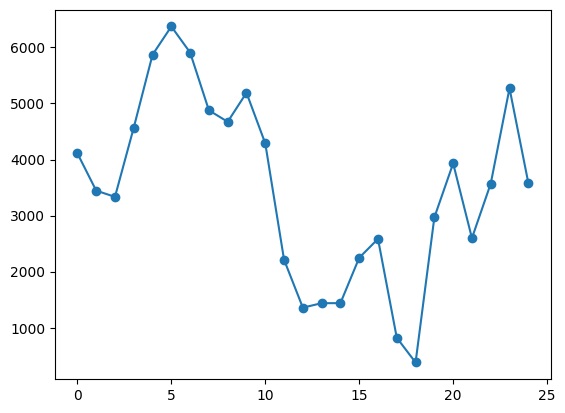

In [9]:
tim_preamb = np.arange(0,len(preamble_df)*Ts,Ts)
plt.plot(iq_samples[arg[max_iq]:arg[max_iq]+25],marker = "o")

Downlink Format
annyi mintát kellene venni ahány belefér a következő 5 us-ba

Darabokra szedjük az üzenetet - DF/AC/ICAO ....

480

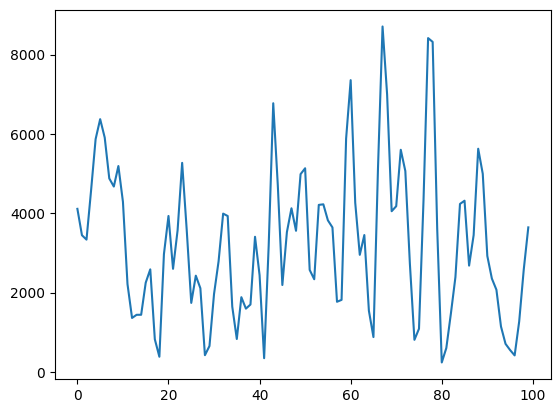

In [10]:
#-----a preamble részhez tartozó minták-----#
start = arg[max_iq]
stop1 = start + math.floor(8*10**-6/Ts)
PREAMBLE = iq_samples[start:stop1]
#----------------DF mintái------------------#
stop2 = stop1 + math.floor(5*10**-6/Ts)
DF = iq_samples[stop1:stop2]
#----------------CA mintái------------------#
stop3 = stop2 + math.floor(3*10**-6/Ts)
CA = iq_samples[stop2:stop3]
#----------------ICAO mintái------------------#
stop4 = stop3 + math.floor(24*10**-6/Ts)
ICAO = iq_samples[stop3:stop4]
#----------------ME mintái------------------#
stop5 = stop4 + math.floor(56*10**-6/Ts)
ME = iq_samples[stop4:stop5]
#----------------PI mintái------------------#
stop6 = stop5 + math.floor(24*10**-6/Ts)
PI = iq_samples[stop5:stop6]
full = np.concatenate([PREAMBLE,DF,CA,ICAO,ME,PI])
plt.plot(full[:100])
len(full)

Kiátlagoljuk n mintánként a biteket, hogy kiküszöböljük a jelszint ingadozást

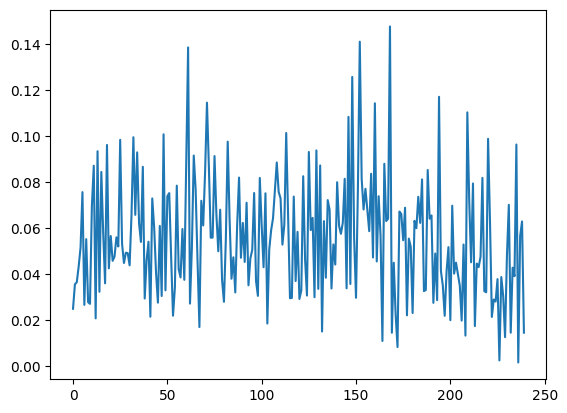

In [35]:
Tb = 0.5*10**-6
avg_num_bit = Tb*fs
int(avg_num_bit)
temp = np.zeros(240)
index = np.arange(0,240,5)
for n in range(240):
    temp[n] = np.average(full[n*5:n*5+4])
full = temp
plt.plot(full)

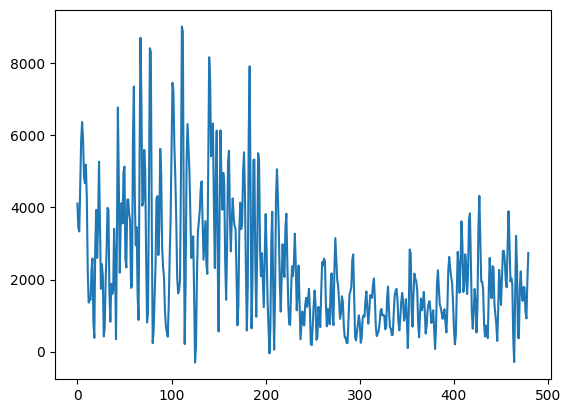

In [11]:
max_match = arg[max_iq]
plt.plot(iq_samples[max_match:max_match+len(full)])

Eldöntjük hogy 0 vagy 1: fele felett 1 alatta 0

3002.181502638038 2206.5889425672094


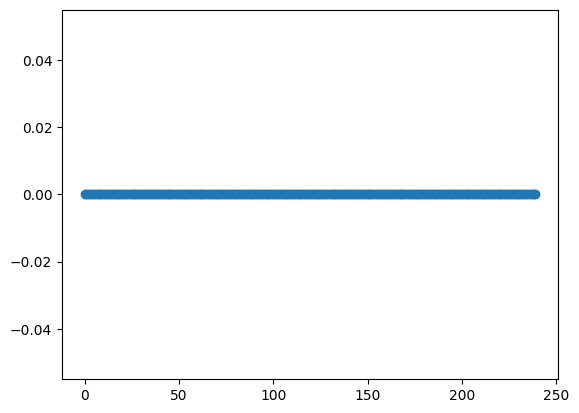

In [98]:
#full = (full/np.max(np.abs(full))+1)/2
LIM = np.min(full)+((np.max(full)-np.min(full))/2)
i = max_iq
avg_zeros = np.average([iq_samples[i+3],iq_samples[i+4],iq_samples[i+5],iq_samples[i+6],iq_samples[i+10],
                       iq_samples[i+11],iq_samples[i+12],iq_samples[i+13],iq_samples[i+14],iq_samples[i+15]])
avg_ones = np.average([iq_samples[i],iq_samples[i+2],iq_samples[i+7],iq_samples[i+9],iq_samples[i+16],
                       iq_samples[i+19],iq_samples[i+21],iq_samples[i+23],iq_samples[i+24]])
LIM = avg_zeros+((avg_ones-avg_zeros)/2)
for i in range(len(full)):
    if full[i] >= LIM:
        full[i] = 1
    else:
        full[i] = 0

plt.plot(full,marker = "o")
print(avg_ones,avg_zeros)

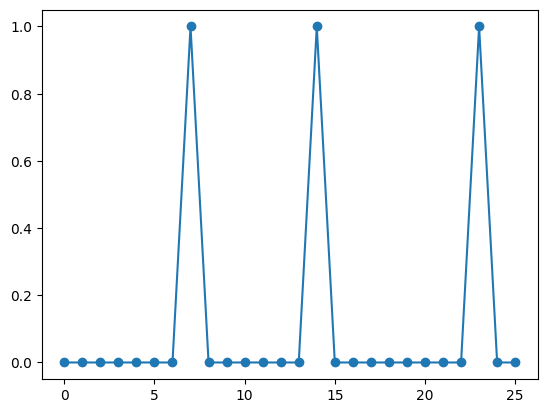

In [78]:
plt.plot(full[:26],marker = "o")

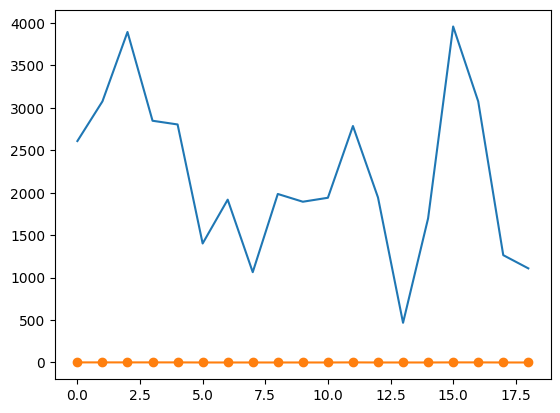

In [13]:
plt.plot(PREAMBLE)
LIM = np.min(PREAMBLE)+((np.max(PREAMBLE)-np.min(PREAMBLE))/2)
for i in range(len(PREAMBLE)):
    if PREAMBLE[i] >= LIM:
        PREAMBLE[i] = 1
    else:
        PREAMBLE[i] = 0

plt.plot(PREAMBLE,marker = "o")

Eldöntjük, hogy mik voltak a bitek értékei az eredeti küldött üzenetben: időzítés

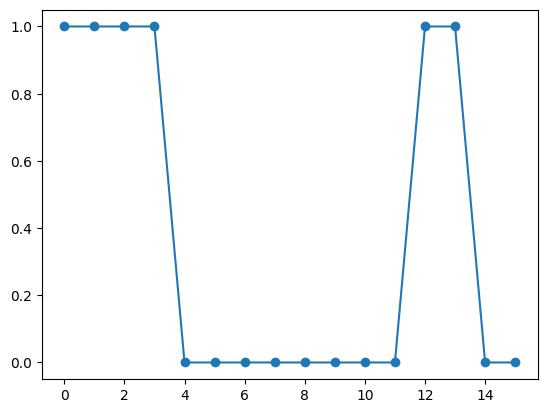

In [14]:
Tb = 0.5*10**-6
preamble_bitek = np.zeros(16)
for i in range(len(preamble_bitek)):
    for j in range(len(PREAMBLE)):
        if (i*Tb<= j*Ts <= (i+1)*Tb):
            preamble_bitek[i] = PREAMBLE[j]

#plt.plot(PREAMBLE)
plt.plot(preamble_bitek, marker = "o")

### HA 1 BITEN BELÜL 2 MINTA IS JÖTT ÉS AZOK KÜLÖNBÖZNEK AKKOR MI LESZ?

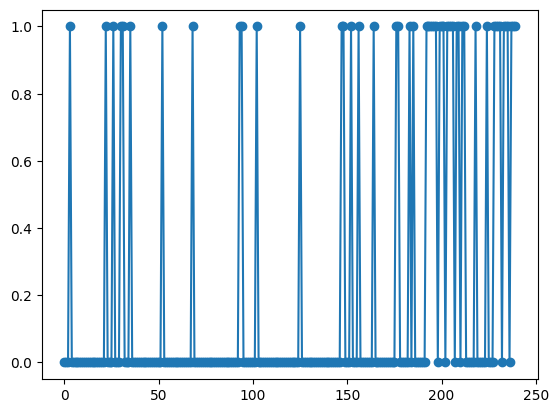

In [23]:
Tb = 0.5*10**-6
full_bitek = np.zeros(240)
for i in range(len(full_bitek)):
    for j in range(len(full)):
        if (i*Tb<= j*Ts <= (i+1)*Tb):
            full_bitek[i] = full[j]

#plt.plot(PREAMBLE)
plt.plot(full_bitek, marker = "o")

A preamble részt külön kezeljük, utána kettesével eldöntjük, hogy 01---0    vagy    10----1 jött

In [79]:
# ennyi minta per bit
#k = 0.5*10**-6/Ts
preamble_bits = np.zeros(16)
bits = np.zeros(112)
np.int64(bits)
full_bitek = full
preamble_bits = full_bitek[:16]
full_bitek = full_bitek[16:]
#print(preamble_bits,full_bitek[:16])
#   0011 lesz '0'    1100 lesz '1'
"""#--------------------------4 MSPS-------------------------------#
for n in range(112):
    if ((full_bitek[4*n] == 0) and (full_bitek[4*n+1] == 0)) and ((full_bitek[4*n+2] == 1) and (full_bitek[4*n+3] == 1)):
        bits[n] = 0
    elif ((full_bitek[4*n] == 1) and (full_bitek[4*n+1] == 1)) and ((full_bitek[4*n+2] == 0) and (full_bitek[4*n+3] == 0)):
        bits[n] = 1
    else:
        bits[n] = -1
"""
#-------------------------2 MSPS--------------------------------#
for n in range(112):
    if ((full_bitek[2*n] == 0) and (full_bitek[2*n+1] == 1)):
        bits[n] = 0
    elif ((full_bitek[2*n] == 1) and (full_bitek[2*n+1] == 0)):
        bits[n] = 1
    else:
        bits[n] = -1
##################################################################
print(bits,full_bitek)

[-1. -1. -1.  0. -1. -1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  0.
  1. -1. -1.  1. -1. -1. -1.  1.  1. -1.  1.  1.  1. -1.  1.  1. -1. -1.
 -1.  0. -1. -1. -1. -1.  0. -1.  0.  0.  0.  1.  1. -1. -1.  1. -1.  1.
 -1.  0. -1. -1.  0. -1.  1. -1.  0.  1.  1.  0.  1. -1. -1. -1.  0.  0.
  0.  0.  0. -1.  0. -1. -1. -1. -1.  0.  0. -1. -1.  0.  0.  0.  0.  0.
  0.  1.  0. -1. -1. -1. -1. -1.  0. -1.  1.  1.  1.  1. -1.  0. -1. -1.
 -1. -1.  1. -1.] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0.
 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.

Bitek szétszedése részekre majd dekódolás

In [29]:
df_bits = bits[:5]
ca_bits = bits[5:8]
icao_bits = bits[8:32]
me_bits = bits[32:88]
pi_bits = bits[88:]
type_code = me_bits[:5]
print(len(me_bits))
print(df_bits,ca_bits,icao_bits,me_bits,pi_bits,type_code)

56
[-1. -1. -1. -1. -1.] [-1. -1. -1.] [-1. -1.  1.  1.  0.  0. -1. -1.  1.  1.  0. -1. -1. -1. -1. -1. -1. -1.
  1.  1.  0.  0.  1.  1.] [-1.  0.  1. -1. -1.  0. -1. -1.  0. -1.  0.  1.  1.  1.  1.  0. -1. -1.
  1. -1.  1. -1.  0.  0. -1. -1. -1.  1.  1.  0. -1.  1. -1. -1.  0.  1.
 -1. -1. -1.  1.  0.  1. -1. -1.  1.  1. -1. -1. -1.  1.  0.  0.  0.  1.
  1. -1.] [-1. -1.  1. -1.  1.  0. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1.
  1.  0. -1.  1.  1. -1.] [-1.  0.  1. -1. -1.]


Átalakítjuk az egyes mezőket a kívánt formátumra

In [ ]:
"""
df_dec = int("".join(df_bits.astype(str)),2)
ca_dec = int("".join(ca_bits.astype(str)),2)
type_code_dec = int("".join(type_code.astype(str)),2)
icao_hex = hex(int("".join(icao_bits.astype(str)),2))
"""

ValueError: invalid literal for int() with base 2: '-1.0-1.0-1.0-1.0-1.0'

In [5]:
import folium

m = folium.Map(location=(47.29,19.02))
folium.Marker(location=(47.29,19.02),popup="hello").add_to(m)
m